In [1]:
!activate adv_ml_env

In [26]:
import json, pickle
from collections import Counter
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from scipy.sparse import vstack, hstack
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from tqdm import tqdm
import sklearn

In [3]:
sklearn.__version__

'1.0.2'

In [4]:
#!wget https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 

In [5]:
#!unzip chgk.zip

1. **Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:**

  a) взять в тренировочный набор турниры с dateStart из 2019 года; 

  b) в тестовый — турниры с dateStart из 2020 года.

Прочитаем файлы и дропнем все ненужные данные

In [6]:
def read_pickle_file(fname):
    file = open(fname, 'rb')
    res = pickle.load(file)
    file.close()
    return res
results_data = read_pickle_file('results.pkl')
players_data = read_pickle_file('players.pkl')
tournaments_data = read_pickle_file('tournaments.pkl')

In [7]:
df_players = pd.DataFrame(players_data.values()).set_index("id")
df_tournaments = pd.DataFrame(tournaments_data.values()).set_index("id")

df_tournaments["year"] = df_tournaments["dateStart"].apply(lambda x: int(x[:4]))
df_train_tournaments = df_tournaments[df_tournaments["year"] == 2019]
df_test_tournaments = df_tournaments[df_tournaments["year"] == 2020]

Сформируем данные для обучения

In [8]:
train_tourn_res = []

player_ids = []
question_ids = []
for tourn_id in df_train_tournaments.index:
    tourn_res = results_data[tourn_id]
    total_questions = set()

    mask = ""
    for team in tourn_res:
        if team.get('mask') is not None:
            total_questions.add(len(team['mask'].replace("?", "").replace("X", "")))
        else:
            continue
  
    if len(total_questions) > 1:
        continue

    for team_res in tourn_res:        
        tmp = {'tourn_id': [],
               'mask': [],
               'team_id': [],
               'player_ids': []}
        if team_res.get("mask") is None or team_res.get("teamMembers") is None or len(team_res["teamMembers"]) < 1:
                continue
        mask = team_res["mask"].replace("?", "").replace("X", "")
        tmp['tourn_id'] =  tourn_id
        tmp['mask'] = list(map(int, mask))
        tmp['team_id'] = team_res['team']['id']
        tmp['player_ids'] = [player["player"]["id"] for player in team_res["teamMembers"]]
        player_ids.extend([player["player"]["id"] for player in team_res["teamMembers"]])
        train_tourn_res.append(tmp)

    if mask:
        for idx, _ in enumerate(mask):
            question_ids.append(str(tourn_id) + "-" + str(idx))
player_ids = list(set(player_ids))

**2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:**

a) повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;

b) в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;

c) для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

обучим модель на следующих данных: возьмем 2 ohe сложенных вектора, один оценивает навык игрока, а второй - сложность вопроса. Веса модели будут отвечать за навык игрока и сложность модели.

In [9]:
ohe_players = OneHotEncoder()
ohe_questions = OneHotEncoder()
player_ids = np.array(player_ids).reshape(-1, 1)
ohe_player_ids = ohe_players.fit_transform(player_ids)

question_ids = np.array(question_ids).reshape(-1, 1)
ohe_question_ids = ohe_questions.fit_transform(question_ids)

In [10]:
dataset_logreg = []
targets = []
for tourn in tqdm(train_tourn_res):
    
    
    players_vec = np.array([np.zeros(len(tourn['mask'])) + int(pl_id) for pl_id in tourn['player_ids']], dtype='int').reshape(-1, 1)
    ohe_players_matr = ohe_players.transform(players_vec)
  
    q_mask_vec = [f'{str(tourn["tourn_id"])}-{str(idx)}' for idx in range(len(tourn['mask']))]
    q_mask = np.tile(q_mask_vec, len(tourn['player_ids'])).reshape(-1, 1)
    ohe_questions_matr = ohe_questions.transform(q_mask)

    targets.append(np.tile(tourn['mask'], len(tourn['player_ids'])).reshape(-1, 1))
    dataset_logreg.append(hstack([ohe_players_matr, ohe_questions_matr]))

100%|████████████████████████████████████████████████████████████████████████████| 76490/76490 [43:40<00:00, 29.19it/s]


In [11]:
dataset = vstack(dataset_logreg)
target = np.vstack(targets)

In [12]:
log_reg = LogisticRegression(solver='saga')
log_reg.fit(dataset, target)

D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='saga')

In [13]:
all_pl = []
for team_in_tourn in train_tourn_res:
    for player_id in team_in_tourn["player_ids"]:
        if player_id not in all_pl:
            all_pl.append(player_id)

rating = pd.DataFrame({'player_ids': sorted(all_pl),
                       'strength': log_reg.coef_[0][:len(all_pl)]})

In [14]:
player_count_games_vocab = Counter()

for team in train_tourn_res:
    for player_id in team["player_ids"]:
        player_count_games_vocab[player_id] += len(team["mask"])

df_player_count_games_vocab = pd.DataFrame.from_dict(player_count_games_vocab, orient='index')
df_player_count_games_vocab["player_ids"] = df_player_count_games_vocab.index

In [15]:
df_players_with_index = df_players.copy()
df_players_with_index["player_ids"] = df_players_with_index.index

rating = df_players_with_index.merge(rating, on="player_ids")
rating = rating.merge(df_player_count_games_vocab, on="player_ids")

In [16]:
rating.sort_values(by='strength', ascending=False).head(50)

,name,patronymic,surname,player_ids,strength,0
3832,Максим,Михайлович,Руссо,27403,4.164988,2092
601,Александра,Владимировна,Брутер,4270,4.033631,2606
4021,Иван,Николаевич,Семушин,28751,3.984042,3643
3904,Михаил,Владимирович,Савченков,27822,3.895232,3048
4207,Артём,Сергеевич,Сорожкин,30152,3.815794,4721
4227,Сергей,Леонидович,Спешков,30270,3.815682,3570
2908,Станислав,Григорьевич,Мереминский,20691,3.691022,1548
2553,Михаил,Ильич,Левандовский,18036,3.639104,1365
3202,Сергей,Игоревич,Николенко,22799,3.564362,2093
3652,Ирина,Сергеевна,Прокофьева,26089,3.561361,939


**Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:**

1) предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

2) в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Text(0.5, 1.0, 'Распределение сложености вопросов')

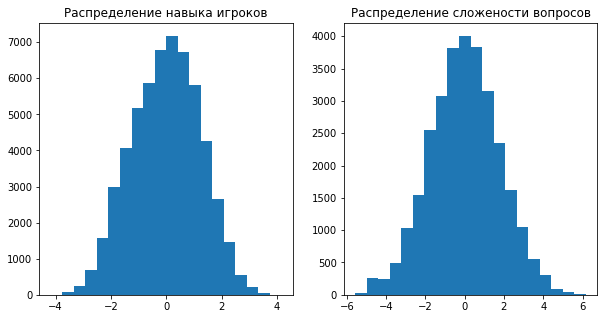

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(rating[["strength"]].values, bins=20)
ax1.set_title('Распределение навыка игроков')
ax2.hist(log_reg.coef_[0][len(all_pl):], bins=20)
ax2.set_title('Распределение сложености вопросов')

In [18]:
log_reg.coef_[0][len(all_pl):].mean()

-0.00011139415735723506

In [19]:
middle_question = np.abs(log_reg.coef_[0][len(all_pl):]).min()
question_index = np.where(log_reg.coef_[0][len(all_pl):] == middle_question)
middle_question = ohe_questions.categories_[0][question_index[0][0]]

In [20]:
test_tourn_res = []

for tourn_id in df_test_tournaments.index:
    tourn_res = results_data[tourn_id]
    total_questions = set()
    data_tournament_results = []
    mask = ""
    for team in tourn_res:
        if team.get('mask') is not None:
            total_questions.add(len(team['mask'].replace("?", "").replace("X", "")))
        else:
            continue
  
    if len(total_questions) > 1:
        continue
    for team_res in tourn_res:  
        tmp = {'tourn_id': [],
               'mask': [],
               'team_id': [],
               'pos': [],
               'player_ids': []}
        if team_res.get("mask") is None or team_res.get("teamMembers") is None or len(team_res["teamMembers"]) < 1:
                continue
        mask = team_res["mask"].replace("?", "").replace("X", "")
        tmp['tourn_id'] =  tourn_id
        tmp['mask'] = list(map(int, mask))
        tmp['pos'] = team_res['position']
        tmp['team_id'] = team_res['team']['id']

        tmp['player_ids'] = [player["player"]["id"] for player in team_res["teamMembers"]]
        data_tournament_results.append(tmp)
    if mask:
        test_tourn_res.append(data_tournament_results)

Попробуем по-другому считать скилл команды. Будем считать вероятность правильного ответа команды на "средний" вопрос по формуле:  

$S = 1 - Π_{i∈team}(1 - σ[s_i, mq]), \sigma$  - вероятность игрока из команды ответить на вопрос

In [21]:
def calc_score(model):
    test_results = {}
    for tourn in tqdm(test_tourn_res):
        tourn_res = {}
        for team in tourn:            
            g_truth = team['pos']
            team_members = []
            for player_id in team["player_ids"]:
                try:
                    ohe_players.transform([[player_id]])
                    team_members.append(player_id)
                except ValueError:
                    continue   
            if len(team_members) == 0:
                    continue
            players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
            question_matrix = ohe_questions.transform(np.full((len(team_members), 1), middle_question))
            tmp_dataset = hstack([players_matrix, question_matrix])
            preds = model.predict_proba(tmp_dataset)[:, 1]
            team_skill = 1 - np.product(1 - preds)
            tourn_res[team["team_id"]] = (team_skill, g_truth)
        test_results[tourn[0]["tourn_id"]] = tourn_res

    spearman_corr = []
    kendall_corr = []

    for tourn in test_results.values():
        predicts = []
        g_truth = []
        for stat in tourn.values():        
            predicts.append(stat[0])
            g_truth.append(stat[1])
        tmp = spearmanr(predicts, g_truth)[0]
        spearman_corr.append(tmp)
        tmp2 = kendalltau(predicts, g_truth)[0]
        kendall_corr.append(tmp2)

    spearman_corr_res = np.abs(np.mean([t for t in spearman_corr if np.isfinite(t)]))
    kendall_corr_res = np.abs(np.mean([t for t in kendall_corr if np.isfinite(t)]))
    return spearman_corr_res, kendall_corr_res

spearman_corr_res, kendall_corr_res = calc_score(log_reg)
print(f"Spearman correlation: {spearman_corr_res}")
print(f"Kendall correlation: {kendall_corr_res}")

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [11:16<00:00,  4.10s/it]

Spearman correlation: 0.806283032151602
Kendall correlation: 0.6484109106302081


**4.Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:**

a) предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;

b) разработайте EM-схему для обучения этой модели, реализуйте её в коде;

c) обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

* E-шаг: находим мат. ожидания $z_i{}_j$ (мат. ожидание того, что игрок i правильно ответил на вопрос j). 

1) $E[z_i{}_j] = 0$, если вся команда не ответила на вопрос $j$.

2) $E[z_i{}_j] = \frac{\sigma [skill_i, question_j]}{1 - \prod_{n \in team} (1 - \sigma [skill_n, question_j])}$, если комада ответила на вопрос $j$. 

Формулу из п.2 получаем по теореме Байеса: 

Пусть событие A - команда правильно ответила на вопрос. Тогда событие B - игрок из команды правильно ответил на вопрос.

$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$; $P(A|B) = 1$ (если игрок ответил на вопрос, то и комада ответила на вопрос). В таком случае: $P(B|A) = \frac{P(B)}{P(A)}$

* M-шаг: пересчитываем параметры логистической регрессии, используя новые z.

In [22]:
def step_e(model, data, target):
    e_z = []
    predict_prob = model.predict_proba(data)[:, 1]
    start = 0
    for team in tqdm(train_tourn_res):
        team_size = len(team["player_ids"])
        mask_size = len(team["mask"])
        team_preds = predict_prob[start : start + team_size * mask_size]
        team_answers = predict_prob[start: start + team_size * mask_size]
        true_team_answers = target[start: start + mask_size]
        team_answers = team_answers.reshape((-1, mask_size)).T
        p_z = 1 - np.prod(1 - team_answers, axis=1)
        team_answers = team_answers / p_z.reshape(-1, 1)
        team_answers = np.where(true_team_answers != 0, team_answers, 0)
        predict_prob[start: start + team_size * mask_size] = team_answers.T.reshape(-1) 
        start += team_size * mask_size   
    return predict_prob

def step_m(e_z, dataset):
    e_z = np.array(e_z)
    fst_target = np.full((dataset.shape[0], 1), 0)
    sec_target = np.full((dataset.shape[0], 1), 1)
    targets = np.vstack((fst_target, sec_target))
    x = vstack([dataset, dataset])
    sample_weights = np.hstack((1 - e_z, e_z))
    model = LogisticRegression(solver="saga")
    model.fit(x, targets, sample_weight=sample_weights)
    return model

In [23]:
models_list = []
model = log_reg
for i in range(6):
    e_z = step_e(model, dataset, target)
    model = step_m(e_z, dataset)
    models_list.append(model)
    spearman_corr, kendall_corr = calc_score(model)
    print(f"Spearman correlation: {spearman_corr}")
    print(f"Kendall correlation: {kendall_corr}")

100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:00<00:00, 78702.17it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [11:22<00:00,  4.13s/it]


Spearman correlation: 0.8132039174783648
Kendall correlation: 0.6552289057695223


100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:00<00:00, 80626.29it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [11:24<00:00,  4.15s/it]


Spearman correlation: 0.8131878388953905
Kendall correlation: 0.6551355564978731


100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:00<00:00, 82859.98it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [10:59<00:00,  4.00s/it]


Spearman correlation: 0.8123023389546691
Kendall correlation: 0.6547766253413242


100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:00<00:00, 81823.68it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [11:02<00:00,  4.01s/it]


Spearman correlation: 0.8118777930165298
Kendall correlation: 0.6551921300614594


100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:01<00:00, 74699.34it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [10:57<00:00,  3.99s/it]


Spearman correlation: 0.8116375671561493
Kendall correlation: 0.654875906962823


100%|█████████████████████████████████████████████████████████████████████████| 76490/76490 [00:00<00:00, 81665.80it/s]
D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [11:06<00:00,  4.04s/it]

Spearman correlation: 0.8116328881729166
Kendall correlation: 0.6544071691055959


In [24]:
best_model = models_list[0]

**5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).**


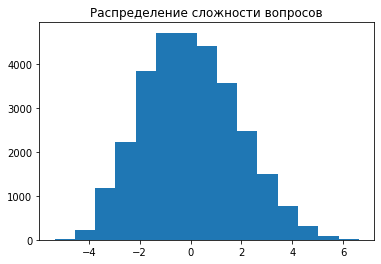

In [47]:
plt.hist(best_model.coef_[0][len(all_pl):], bins=15)
plt.title("Распределение сложности вопросов")
plt.show()

In [48]:
tournaments = [[train_tourn_res[0]["tourn_id"], len(train_tourn_res[0]["mask"])]]
for team in train_tourn_res:
    tourn_id = team["tourn_id"]
    mask_size = len(team["mask"])
    if tournaments[-1] != [tourn_id, mask_size]:
        tournaments.append([tourn_id, mask_size])
quest_diff = best_model.coef_[0][len(all_pl):]
tournament_diff = []
i = 0
for tourn in tournaments:
    diff_in_tourn = np.array(quest_diff[i : i + tourn[1]])
    tournament_diff.append([tourn[0], np.mean(diff_in_tourn)])
    i += tourn[1]
    
# легкие турниры
top_hardest = np.array(sorted(tournaments_difficulties, key=lambda x: x[1]))
top_easiest = np.array(sorted(tournaments_difficulties, key=lambda x: x[1], reverse=True))
# сложные турниры
pd_top_hardest = pd.DataFrame(df_train_tournaments.loc[top_hardest[:, 0]].name)
pd_top_easiest = pd.DataFrame(df_train_tournaments.loc[top_easiest[:, 0]].name)

In [49]:
pd_top_easiest.head(20)

,name
id,
5013.0,(а)Синхрон-lite. Лига старта. Эпизод V
5438.0,Синхрон Лиги Разума
5009.0,(а)Синхрон-lite. Лига старта. Эпизод III
5702.0,(а)Синхрон-lite. Лига старта. Эпизод IX
5698.0,(а)Синхрон-lite. Лига старта. Эпизод VII
5457.0,Студенческий чемпионат Калининградской области
5011.0,(а)Синхрон-lite. Лига старта. Эпизод IV
5313.0,(а)Синхрон-lite. Лига старта. Эпизод VI
5012.0,Школьный Синхрон-lite. Выпуск 2.5


In [50]:
pd_top_hardest.head(20)

,name
id,
6149.0,Чемпионат Санкт-Петербурга. Первая лига
5928.0,Угрюмый Ёрш
5159.0,Первенство правого полушария
5684.0,Синхрон высшей лиги Москвы
5025.0,Кубок городов
6101.0,Воображаемый музей
5587.0,Записки охотника
5083.0,Ускользающая сова
5465.0,Чемпионат России
